# Dialogue Tags Analysis

In [1]:
%%javascript
// Disable auto-scroll
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
%pylab inline
pylab.rcParams['figure.figsize'] = (13, 10)

import math
import pandas as pd
import seaborn as sns
import scipy as sp
import scipy.stats as stats

from pandas.plotting import parallel_coordinates
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import VarianceThreshold


from collections import Counter
import statsmodels.api as sm
import itertools

Populating the interactive namespace from numpy and matplotlib


/Users/victor/miniconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
scores = pd.read_csv("../data/ES_2-5_79cases_newVnames.csv")
scores.head();

In [4]:
labels = pd.read_csv("../data/transcripts/dialogues/prepLIWC_allFiles.trigrams.ctxc0-1.cnt2.seq.label.withnames", sep="\t", names=["meta", "label"])
labels.head();

In [5]:
labels['filename'] = labels['meta'].apply(lambda x: x.split(".")[0])
labels['lineno'] = labels['meta'].apply(lambda x: x.split(".")[1])
labels['speaker'] = labels['meta'].apply(lambda x: x.split(".")[2].strip())
labels.head();

In [6]:
# Var for therapists
therapist = ['Interviewer', 'Therapist']
labels['therapist'] = False
labels.loc[labels['speaker'].isin(therapist),'therapist'] = True
labels.head();

In [7]:
labels['FAMILY'] = labels['filename'].apply(lambda x: x.split()[0].split("-")[0].split("_")[0].replace("A2FB", ""))
labels.head();

In [8]:
unq_labels = sorted(labels.label.unique())
unq_labels;

In [9]:
print("# of families (labels):", len(labels.FAMILY.unique()))
print("# of families (scores):", len(scores.FAMILY.unique()))
print("# of families (intersection):", len(set(labels.FAMILY).intersection(set(scores.FAMILY))))
print()
print("# of labels: ", len(unq_labels))

# of families (labels): 21
# of families (scores): 79
# of families (intersection): 19

# of labels:  7


In [10]:
# Agg into counts of label
tmp = labels.groupby(['FAMILY', 'therapist', 'label']).agg(len)
tmp.reset_index(inplace = True)
tmp = tmp.rename(columns={'meta':'frequency'})
tmp = tmp.drop(['filename', 'lineno', 'speaker'], axis = 1)
tmp.head();

In [11]:
data = pd.merge(tmp, scores[['FAMILY', 'Hop2', 'FB2']], left_on = "FAMILY", right_on = 'FAMILY')
data.head()

,FAMILY,therapist,label,frequency,Hop2,FB2
0,ESC413,False,Agreement,2,6,5.8
1,ESC413,False,Backchannel,22,6,5.8
2,ESC413,False,Other,43,6,5.8
3,ESC413,False,Question,1,6,5.8
4,ESC413,False,Statement,56,6,5.8


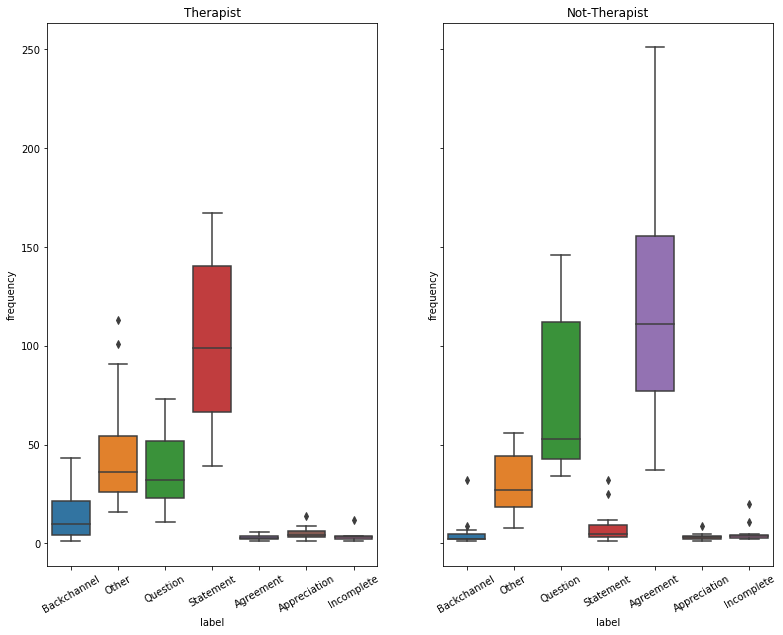

In [12]:
fig, axs = plt.subplots(ncols = 2, sharey = True)
g = sns.boxplot(x = 'label',
            y = 'frequency', data = data[data['therapist'] == True],
            ax = axs[0]);
axs[0].set_title("Therapist")
g = sns.boxplot(x = 'label',
            y = 'frequency',
            data = data[data['therapist'] == False],
            ax = axs[1]);
axs[1].set_title("Not-Therapist")
#plt.ylabel("Freq. of label");
#plt.title("Label frequency for therapist dialogue")

axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation = 30)
axs[1].set_xticklabels(axs[0].get_xticklabels(), rotation = 30)

plt.show();

# Therapist correlations
Calculate the spearman correlation between the frequency of each label and the Hop2 score. 

_update Oct 4th_: Use a linear model instead of going one by one.


First, we create a matrix $X$ where rows are the families and columns are the number of times either therapist or non-therapist used each DA. We then fit a linear model to predict the corresponding COACH score.

## Therapist

In [13]:
therapist_d = data[data.therapist == True]

X = np.zeros((len(therapist_d.FAMILY.unique()), len(unq_labels)))
hop2 = np.zeros((len(therapist_d.FAMILY.unique()),))
fb2 = np.zeros((len(therapist_d.FAMILY.unique()),))

for fam_idx, (fam, grp) in enumerate(therapist_d.groupby('FAMILY')):
    hop2[fam_idx] = grp['Hop2'].unique()[0]
    fb2[fam_idx] = grp['FB2'].unique()[0]
    for label_idx, label in enumerate(unq_labels):
        if np.any(grp.label == label):
            X[fam_idx, label_idx] = grp.loc[grp.label == label, 'frequency']


# Scale X to [0, 1]
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# Name the params
X = pd.DataFrame(X, columns=therapist_d.label.unique())

#add intercept
X = sm.add_constant(X)

### Hop2

In [14]:
# Fit linear model
model = sm.OLS(hop2, X).fit()

# Print R-like summary
model.summary()

/Users/victor/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1334: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.336
Model:                            OLS   Adj. R-squared:                 -0.087
Method:                 Least Squares   F-statistic:                    0.7938
Date:                Wed, 04 Oct 2017   Prob (F-statistic):              0.608
Time:                        13:00:24   Log-Likelihood:                -38.902
No. Observations:                  19   AIC:                             93.80
Df Residuals:                      11   BIC:                             101.4
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            3.6238      1.248      2.903      0.014       0.876       6.371
Backchannel      1.1626      2.829      0.411      0.689      -5.065       7.390
Other            2.8889      3.895      0.742      0.474      -5.684      11.462
Question        -3.4199      4.929     -0.694      0.502     -14.270       7.430
Statement        2.2643      3.681      0.615      0.551      -5.838      10.367
Agreement       -2.8035      6.649     -0.422      0.681     -17.437      11.830
Appreciation     0.7035      4.629      0.152      0.882      -9.484      10.891
Incomplete       2.9260      2.524      1.159      0.271      -2.630       8.482
==============================================================================
Omnibus:                        0.677   Durbin-Watson:                   1.932
Prob(Omnibus):                  0.713   Jarque-Bera (JB):                0.703
Skew:                          -0.357   Prob(JB):                        0.704
Kurtosis:                       2.384   Cond. No.                         22.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### FB2

In [15]:
# Fit linear model
model = sm.OLS(fb2, X).fit()

# Print R-like summary
model.summary()

/Users/victor/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1334: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.304
Model:                            OLS   Adj. R-squared:                 -0.139
Method:                 Least Squares   F-statistic:                    0.6855
Date:                Wed, 04 Oct 2017   Prob (F-statistic):              0.683
Time:                        13:00:24   Log-Likelihood:                -34.906
No. Observations:                  19   AIC:                             85.81
Df Residuals:                      11   BIC:                             93.37
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            4.0217      1.011      3.976      0.002       1.795       6.248
Backchannel      1.3591      2.293      0.593      0.565      -3.687       6.406
Other            2.7309      3.156      0.865      0.405      -4.216       9.678
Question        -0.0119      3.995     -0.003      0.998      -8.804       8.780
Statement        1.2349      2.983      0.414      0.687      -5.331       7.801
Agreement       -4.8901      5.388     -0.908      0.384     -16.748       6.968
Appreciation     1.0483      3.751      0.279      0.785      -7.207       9.304
Incomplete       1.5297      2.045      0.748      0.470      -2.972       6.032
==============================================================================
Omnibus:                        0.875   Durbin-Watson:                   2.037
Prob(Omnibus):                  0.646   Jarque-Bera (JB):                0.744
Skew:                          -0.164   Prob(JB):                        0.689
Kurtosis:                       2.087   Cond. No.                         22.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Non-therapist

In [16]:
therapist_d = data[data.therapist == False]

X = np.zeros((len(therapist_d.FAMILY.unique()), len(unq_labels)))
hop2 = np.zeros((len(therapist_d.FAMILY.unique()),))
fb2 = np.zeros((len(therapist_d.FAMILY.unique()),))

for fam_idx, (fam, grp) in enumerate(therapist_d.groupby('FAMILY')):
    hop2[fam_idx] = grp['Hop2'].unique()[0]
    fb2[fam_idx] = grp['FB2'].unique()[0]
    for label_idx, label in enumerate(unq_labels):
        if np.any(grp.label == label):
            X[fam_idx, label_idx] = grp.loc[grp.label == label, 'frequency']


# Scale X to [0, 1]
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# Name the params
X = pd.DataFrame(X, columns = unq_labels)

X = sm.add_constant(X)

### Hop2

In [17]:
# Fit linear model
model = sm.OLS(hop2, X).fit()

# Print R-like summary
model.summary()

/Users/victor/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1334: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.340
Model:                            OLS   Adj. R-squared:                 -0.080
Method:                 Least Squares   F-statistic:                    0.8089
Date:                Wed, 04 Oct 2017   Prob (F-statistic):              0.598
Time:                        13:00:24   Log-Likelihood:                -38.842
No. Observations:                  19   AIC:                             93.68
Df Residuals:                      11   BIC:                             101.2
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            3.4862      1.388      2.512      0.029       0.432       6.540
Agreement       10.4609      6.395      1.636      0.130      -3.615      24.537
Appreciation     0.3629      3.790      0.096      0.925      -7.978       8.704
Backchannel      1.5896      3.323      0.478      0.642      -5.724       8.903
Incomplete      -8.7626      6.202     -1.413      0.185     -22.414       4.889
Other            2.2113      3.101      0.713      0.491      -4.615       9.038
Question         3.9419      4.941      0.798      0.442      -6.933      14.817
Statement       -1.8627      4.329     -0.430      0.675     -11.391       7.666
==============================================================================
Omnibus:                        0.114   Durbin-Watson:                   1.731
Prob(Omnibus):                  0.945   Jarque-Bera (JB):                0.334
Skew:                           0.067   Prob(JB):                        0.846
Kurtosis:                       2.364   Cond. No.                         22.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### FB2

In [18]:
# Fit linear model
model = sm.OLS(fb2, X).fit()

# Print R-like summary
model.summary()

/Users/victor/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1334: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.260
Model:                            OLS   Adj. R-squared:                 -0.211
Method:                 Least Squares   F-statistic:                    0.5523
Date:                Wed, 04 Oct 2017   Prob (F-statistic):              0.779
Time:                        13:00:24   Log-Likelihood:                -35.485
No. Observations:                  19   AIC:                             86.97
Df Residuals:                      11   BIC:                             94.52
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            4.3892      1.163      3.775      0.003       1.830       6.949
Agreement        6.0995      5.360      1.138      0.279      -5.697      17.896
Appreciation     1.3440      3.176      0.423      0.680      -5.646       8.334
Backchannel     -0.3418      2.785     -0.123      0.905      -6.471       5.787
Incomplete      -4.7567      5.198     -0.915      0.380     -16.197       6.684
Other            1.1727      2.599      0.451      0.661      -4.548       6.893
Question         0.0538      4.141      0.013      0.990      -9.060       9.168
Statement        0.7439      3.628      0.205      0.841      -7.242       8.729
==============================================================================
Omnibus:                        0.752   Durbin-Watson:                   1.776
Prob(Omnibus):                  0.687   Jarque-Bera (JB):                0.671
Skew:                          -0.080   Prob(JB):                        0.715
Kurtosis:                       2.094   Cond. No.                         22.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Pairs of DAs
We now look for correlations between the number of times a pair $(x, y)$ with $x, y \in \{Agreement, Backchannel, \ldots\}$ appear in the conversation with the COACH score.

## Therapist & Non-Therapist Interactions

In [19]:
X = np.zeros((len(data.FAMILY.unique()), len(unq_labels), len(unq_labels)))

for fam_idx, (fam, _) in enumerate(data.groupby('FAMILY')):
    
    # Recover grp from labels (to get seq's of labels)
    grp = labels[labels['FAMILY'] == fam]
    
    # Count pairs of interactions
    c = Counter(zip(grp['label'], grp['label'][1:]))
    
    # Save it to the corresponding column in X
    for x, y in c.keys():
        X[fam_idx, unq_labels.index(x), unq_labels.index(y)] = c[(x, y)]
    
# Collapse additional dimension
X = X.reshape((len(data.FAMILY.unique()), -1))
        
# Scale X to [0, 1]
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# Name the params
X = pd.DataFrame(X, columns = itertools.product(unq_labels, unq_labels))

# Delete columns with small variance
X = X.loc[:, X.var() > 0.1]

X = sm.add_constant(X)
X.head()

,const,"(Agreement, Backchannel)","(Agreement, Incomplete)","(Agreement, Question)","(Appreciation, Backchannel)","(Backchannel, Appreciation)","(Backchannel, Question)","(Backchannel, Statement)","(Other, Other)","(Question, Question)","(Statement, Appreciation)","(Statement, Backchannel)"
0,1.0,0.0,0.0,1.0,0.0,0.0,0.222222,0.277778,0.140845,0.000000,0.000000,0.228070
1,1.0,0.0,0.0,0.0,0.0,0.0,0.222222,0.000000,0.098592,0.000000,0.090909,0.000000
2,1.0,1.0,0.0,0.0,0.0,1.0,1.000000,1.000000,0.619718,0.333333,1.000000,0.964912
3,1.0,0.0,0.0,0.0,0.0,0.0,0.666667,0.148148,0.070423,0.000000,0.090909,0.210526
4,1.0,0.0,0.0,0.0,0.0,0.0,0.333333,0.462963,0.126761,0.000000,0.272727,0.421053


### Hop2

In [20]:
# Fit linear model
model = sm.OLS(hop2, X).fit()

# Print R-like summary
model.summary()

/Users/victor/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1334: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.450
Model:                            OLS   Adj. R-squared:                 -0.413
Method:                 Least Squares   F-statistic:                    0.5215
Date:                Wed, 04 Oct 2017   Prob (F-statistic):              0.839
Time:                        13:00:25   Log-Likelihood:                -37.100
No. Observations:                  19   AIC:                             98.20
Df Residuals:                       7   BIC:                             109.5
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                               4.3741      1.536      2.848      0.025       0.743       8.005
('Agreement', 'Backchannel')        0.7662      2.199      0.348      0.738      -4.434       5.966
('Agreement', 'Incomplete')         0.0092      2.373      0.004      0.997      -5.602       5.620
('Agreement', 'Question')           0.4135      1.873      0.221      0.832      -4.015       4.842
('Appreciation', 'Backchannel')     2.8372      2.491      1.139      0.292      -3.053       8.727
('Backchannel', 'Appreciation')     2.4194      2.213      1.093      0.310      -2.813       7.652
('Backchannel', 'Question')         2.5677      4.823      0.532      0.611      -8.838      13.973
('Backchannel', 'Statement')        1.4146     15.958      0.089      0.932     -36.320      39.149
('Other', 'Other')                  0.9974      4.103      0.243      0.815      -8.705      10.699
('Question', 'Question')            0.7528      3.861      0.195      0.851      -8.377       9.882
('Statement', 'Appreciation')       1.0368      2.767      0.375      0.719      -5.506       7.579
('Statement', 'Backchannel')       -6.8027     18.009     -0.378      0.717     -49.388      35.782
==============================================================================
Omnibus:                        0.686   Durbin-Watson:                   2.047
Prob(Omnibus):                  0.710   Jarque-Bera (JB):                0.714
Skew:                          -0.275   Prob(JB):                        0.700
Kurtosis:                       2.225   Cond. No.                         59.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### FB2

In [21]:
# Fit linear model
model = sm.OLS(fb2, X).fit()

# Print R-like summary
model.summary()

/Users/victor/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1334: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.613
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     1.009
Date:                Wed, 04 Oct 2017   Prob (F-statistic):              0.515
Time:                        13:00:25   Log-Likelihood:                -29.321
No. Observations:                  19   AIC:                             82.64
Df Residuals:                       7   BIC:                             93.98
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                               4.5085      1.020      4.421      0.003       2.097       6.920
('Agreement', 'Backchannel')        0.2717      1.460      0.186      0.858      -3.181       3.724
('Agreement', 'Incomplete')         0.2940      1.576      0.187      0.857      -3.432       4.020
('Agreement', 'Question')           0.4078      1.243      0.328      0.753      -2.533       3.348
('Appreciation', 'Backchannel')     3.1854      1.654      1.926      0.095      -0.726       7.096
('Backchannel', 'Appreciation')     2.2577      1.469      1.537      0.168      -1.217       5.732
('Backchannel', 'Question')         2.4141      3.203      0.754      0.476      -5.160       9.988
('Backchannel', 'Statement')        4.2227     10.596      0.399      0.702     -20.834      29.279
('Other', 'Other')                  1.2638      2.725      0.464      0.657      -5.179       7.706
('Question', 'Question')           -0.9169      2.564     -0.358      0.731      -6.979       5.145
('Statement', 'Appreciation')       1.4811      1.837      0.806      0.447      -2.863       5.826
('Statement', 'Backchannel')       -9.6047     11.959     -0.803      0.448     -37.882      18.673
==============================================================================
Omnibus:                        1.030   Durbin-Watson:                   2.222
Prob(Omnibus):                  0.598   Jarque-Bera (JB):                0.769
Skew:                          -0.089   Prob(JB):                        0.681
Kurtosis:                       2.031   Cond. No.                         59.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Other visualizations
First, we construct a new dataset with labels as columns. We scale this data to be 0 - 1 for the parallel coordinates plot. Since the pivoting procedure drops the scores, we re-merge them just like before.

In [22]:
pivoted_data = pd.pivot_table(data, values = 'frequency', index = ['FAMILY', 'therapist'], columns = 'label')
pivoted_data.reset_index(inplace = True)
pivoted_data = pivoted_data.fillna("0.0")

sel_columns = ['Agreement', 'Appreciation', 'Backchannel', 'Incomplete', 'Other', 'Question', 'Statement']

#Convert columns to numeric
pivoted_data[sel_columns] = pivoted_data[sel_columns].apply(pd.to_numeric)

#Scale to 0 - 1
scaler = MinMaxScaler()
pivoted_data[sel_columns] = scaler.fit_transform(pivoted_data[sel_columns])

pivoted_data.head();

In [23]:
pivoted_data = pd.merge(pivoted_data, scores[['FAMILY', 'Hop2', 'FB2']], on = 'FAMILY')
pivoted_data.head();

In [24]:
pivoted_data['Hop2_HIGH'] = pivoted_data['Hop2'] > sp.median(pivoted_data['Hop2'])

In [25]:
pivoted_therapist = pivoted_data[pivoted_data['therapist'] == True].drop('therapist', axis = 1)
pivoted_other = pivoted_data[pivoted_data['therapist'] == False].drop('therapist', axis = 1)

### Parallel coordinates (aka The Jackson Pollock plot)

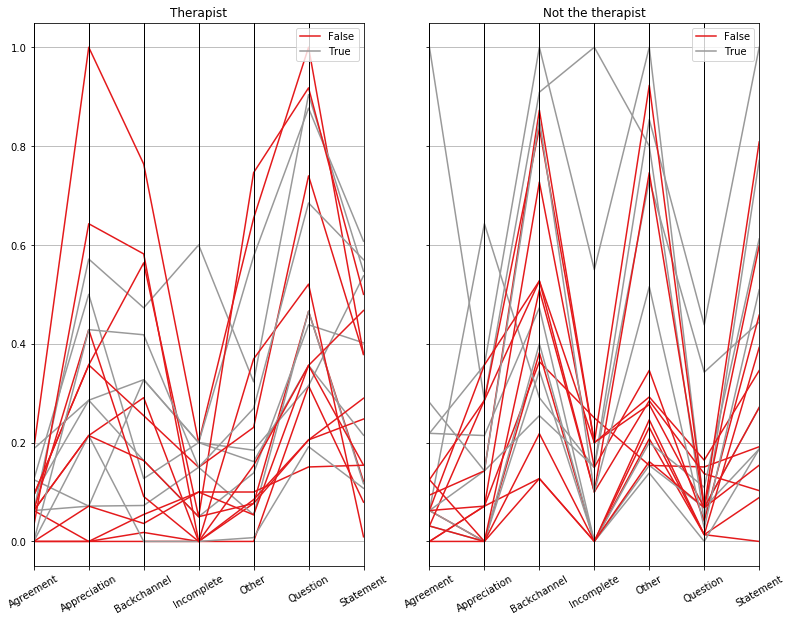

In [26]:
fig, axs = plt.subplots(ncols = 2, sharey = True)
parallel_coordinates(pivoted_therapist.drop(['Hop2', 'FB2', 'FAMILY'], axis = 1), 'Hop2_HIGH', colormap = "Set1", ax=axs[0]);
axs[0].set_title("Therapist");

parallel_coordinates(pivoted_other.drop(['Hop2', 'FB2', 'FAMILY'], axis = 1), 'Hop2_HIGH', colormap = "Set1", ax=axs[1]);
axs[1].set_title("Not the therapist");

axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation = 30)
axs[1].set_xticklabels(axs[0].get_xticklabels(), rotation = 30)


plt.show();

### Paired plot

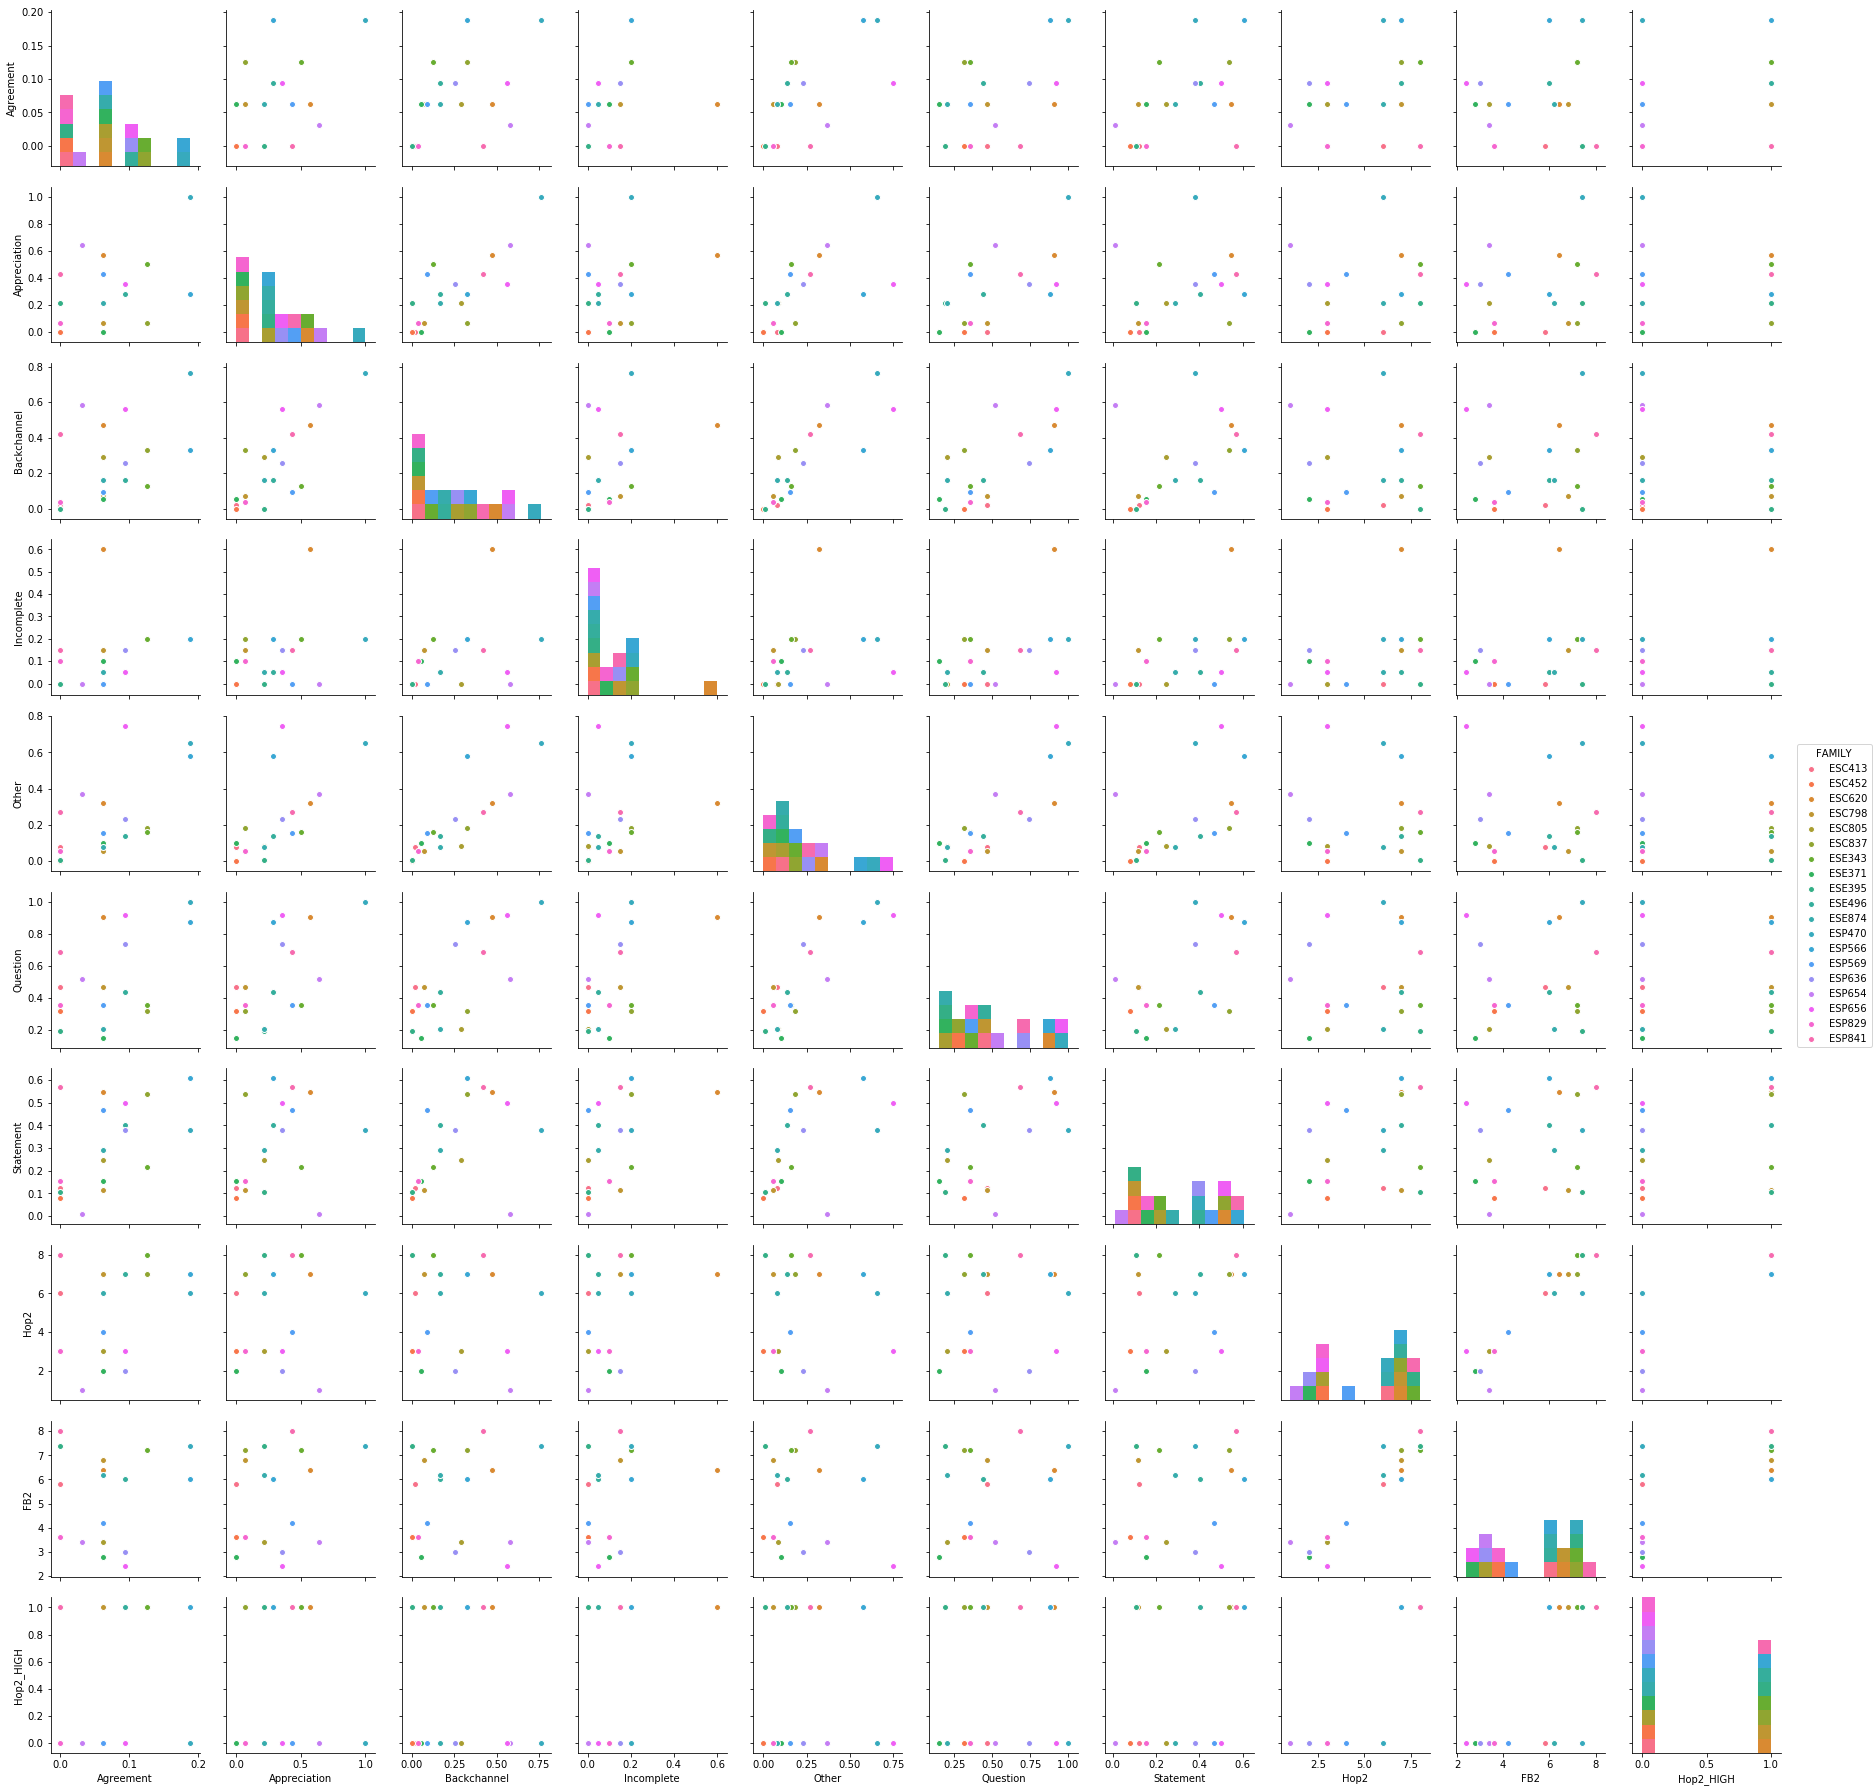

In [27]:
sns.pairplot(pivoted_therapist, hue = 'FAMILY')

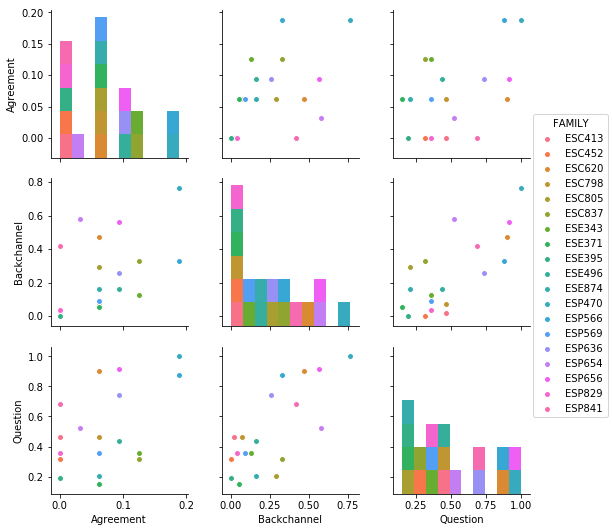

In [28]:
sns.pairplot(pivoted_therapist, hue = 'FAMILY', vars = ['Agreement', 'Backchannel', 'Question'])

### Linear relationship plot
The following figures plot the linear relationship between number of X and the Hop2 rating, where X is one of the labels given by the language model. Therapist and not-Therapist dialogue is split into columns. Each plot also shows the 95% confidence interval for the regression estimate (i.e., translucent bands around the regression line). The confidence interval is estimated using a bootstrap procedure.

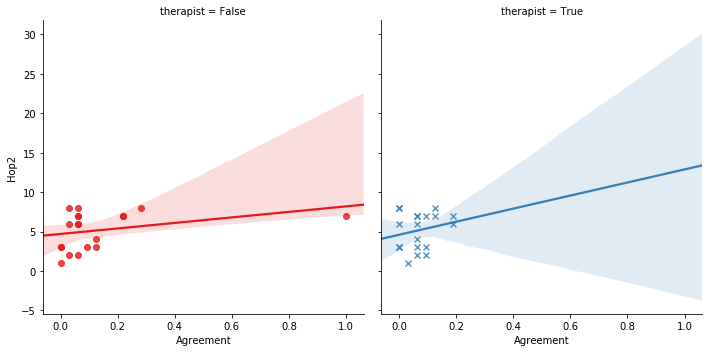

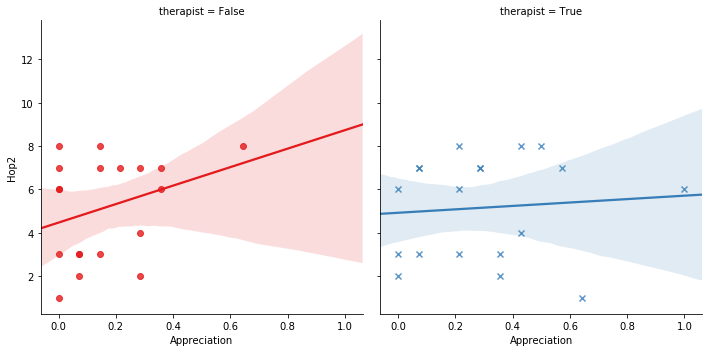

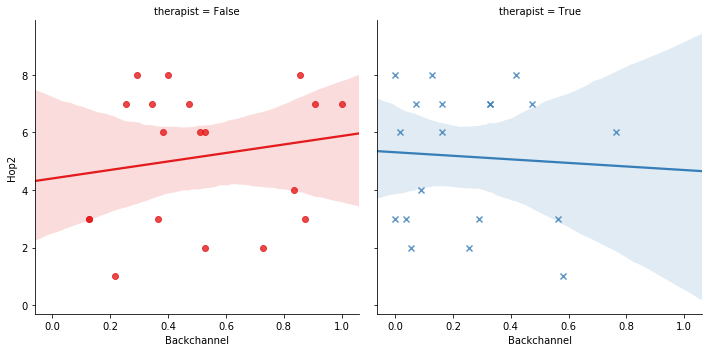

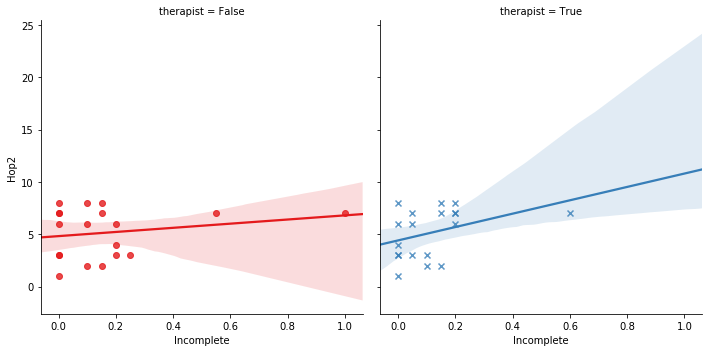

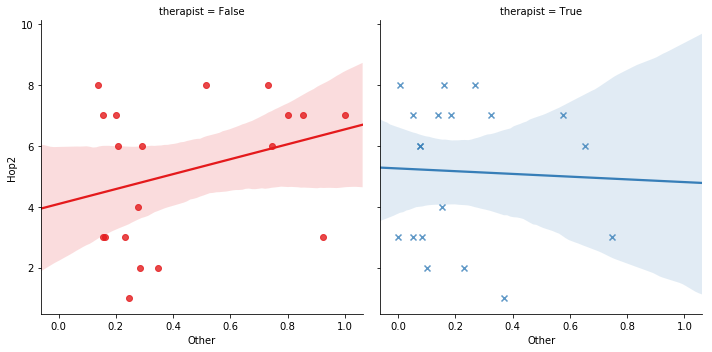

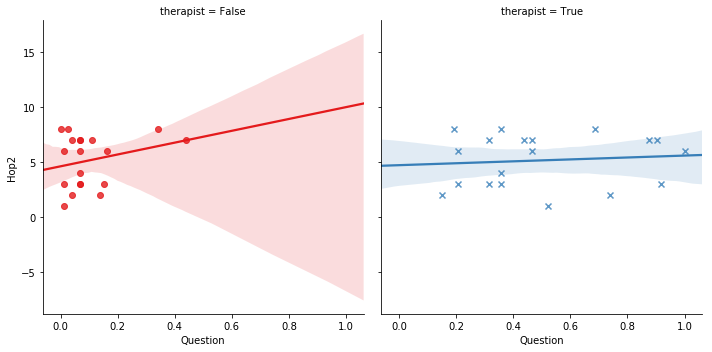

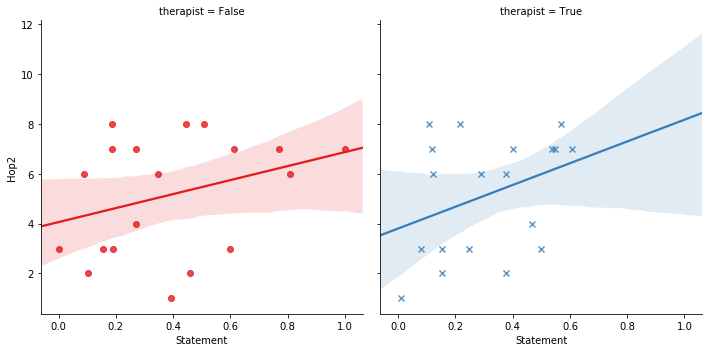

In [29]:
for col in sel_columns:
    sns.lmplot(x = col, y = "Hop2", hue = "therapist", col = "therapist", data = pivoted_data, markers=["o", "x"], palette="Set1");